In [ ]:
#PIPELINE ETL SUL CINEMA E SULLE SERIE TV
import requests
from datetime import datetime, timedelta
import pandas as pd
import json

#URL:UNIFORM RESOURCE LOCATOR DI CONNESSIONE PER LA CHIAMATA API ai FILM
urlMOVIE = "https://api.themoviedb.org/3/discover/movie"

#PARAMETRI API (api_key obbligatoria)
#IMPORTANTE questi parametri sono rappresentanti in Python da un dizionario
#() tupla es (1,2,3) questa è una tripla;
#[] lista
#{} Dizionario: lista di valori accopiati nel formato chiave:valore
#Da chi è determinato il formato delle chiavi nelle chiamate API?
#è determinato dal FORNITORE (in questo caso themoviedb) e le istruzioni si trovano all'interno delle
#documentazione API -> all'interno troviamo il SET di chiavi
#IMPORTANTE 2: api_key è diverso da Api_key le chiamate API sono case-sensitive ovvero disambiguano tra
#maiuscole e minuscole

ps = {
    'api_key': '14c72b3aec191525f8d110ac5d82ac41',
    'language': 'it-IT',
    'with_origin_country': 'IT',
    'with_original_language': 'it',
    'primary_release_date.gte': (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
}
response = requests.get(urlMOVIE, params=ps)

#URL DI CONNESSIONE PER LA CHIAMATA API alle serie tv
urlTV = "https://api.themoviedb.org/3/discover/tv"
response_tv = requests.get(urlTV, params=ps)

#Usiamo json.loads per caricare in formato json dentro una variabile il contenuto della risposta
movies_data = json.loads(response.content)
tv_data = json.loads(response_tv.content)

df_movies = pd.DataFrame(movies_data['results'])
df_tv = pd.DataFrame(tv_data['results'])

display(df_movies.head())
display(df_tv.head())

In [31]:
df_film = df_movies[['genre_ids', 'original_title', 'overview', 'popularity', 'release_date', 'vote_average', 'vote_count']].copy()
df_serie = df_tv[['genre_ids', 'original_name', 'overview', 'popularity', 'first_air_date', 'vote_average', 'vote_count']].copy()

df_film['categoria'] = 'film'
df_serie['categoria'] = 'serie'

df_film.rename(columns={'original_title': 'titolo'}, inplace=True)
df_serie.rename(columns={'original_name': 'titolo'}, inplace=True)

df_film.rename(columns={'release_date': 'anno_uscita'}, inplace=True)
df_serie.rename(columns={'first_air_date': 'anno_uscita'}, inplace=True)

df_combined = pd.concat([df_film, df_serie], ignore_index=True)

display(df_combined.head())

,genre_ids,titolo,overview,popularity,anno_uscita,vote_average,vote_count,categoria
0,"[35, 18]",Diamanti,"Un regista convoca le sue attrici preferite, q...",32.9772,2024-12-19,7.219,265,film
1,[35],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",18.4953,2025-03-27,6.000,38,film
2,[],Mantis,,13.7500,2025-09-19,0.000,0,film
3,[18],Diciannove,Il film racconta la storia di un diciannovenne...,8.4807,2025-02-27,6.300,9,film
4,"[18, 53]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",5.8621,2025-09-05,6.000,15,film


In [32]:
def ottieni_punteggi_recensioni(titolo):
    """
    Ottiene i punteggi delle recensioni per un dato titolo dal servizio OMDb API.

    Args:
        titolo: Il titolo del film o della serie TV.

    Returns:
        Una tupla contenente i punteggi di IMDb, Rotten Tomatoes e Metacritic,
        o ('N/A', 'N/A', 'N/A') in caso di errore o titolo non trovato.
    """
    url_base_omdb = "https://www.omdbapi.com/"
    chiave_api = "8a51429c"

    # Formatta il titolo per l'URL (sostituisce gli spazi con '+')
    titolo_formattato = titolo.replace(" ", "+")
    url_richiesta = f"{url_base_omdb}?t={titolo_formattato}&apikey={chiave_api}"

    try:
        risposta = requests.get(url_richiesta)
        dati_recensioni = json.loads(risposta.content)

        # Controlla se la chiamata API ha avuto successo
        if dati_recensioni.get("Response") == "True":
            recensioni = dati_recensioni.get("Ratings", [])

            punteggio_imdb = "N/A"
            punteggio_rotten_tomatoes = "N/A"
            punteggio_metacritic = "N/A"

            for recensione in recensioni:
                if recensione.get("Source") == "Internet Movie Database":
                    punteggio_imdb = recensione.get("Value", "N/A")
                elif recensione.get("Source") == "Rotten Tomatoes":
                    punteggio_rotten_tomatoes = recensione.get("Value", "N/A")
                elif recensione.get("Source") == "Metacritic":
                    punteggio_metacritic = recensione.get("Value", "N/A")

            return punteggio_imdb, punteggio_rotten_tomatoes, punteggio_metacritic
        else:
            # Se la chiamata API non ha avuto successo (titolo non trovato, ecc.)
            return "N/A", "N/A", "N/A"
    except requests.exceptions.RequestException:
        # Gestisce eventuali errori di connessione o altri errori di richiesta
        return "N/A", "N/A", "N/A"


In [33]:
# Apply the function to the 'titolo' column and create new columns for the scores
df_combined[['punteggio_imdb', 'punteggio_rotten_tomatoes', 'punteggio_metacritic']] = df_combined['titolo'].apply(lambda x: ottieni_punteggi_recensioni(x)).apply(pd.Series)

# Display the updated DataFrame
display(df_combined.head())

,genre_ids,titolo,overview,popularity,anno_uscita,vote_average,vote_count,categoria,punteggio_imdb,punteggio_rotten_tomatoes,punteggio_metacritic
0,"[35, 18]",Diamanti,"Un regista convoca le sue attrici preferite, q...",32.9772,2024-12-19,7.219,265,film,6.8/10,N/A,N/A
1,[35],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",18.4953,2025-03-27,6.000,38,film,N/A,N/A,N/A
2,[],Mantis,,13.7500,2025-09-19,0.000,0,film,5.3/10,N/A,N/A
3,[18],Diciannove,Il film racconta la storia di un diciannovenne...,8.4807,2025-02-27,6.300,9,film,N/A,74%,N/A
4,"[18, 53]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",5.8621,2025-09-05,6.000,15,film,N/A,N/A,N/A


In [34]:
import numpy as np

def normalizza_e_media_punteggi(row):
    """
    Normalizza i punteggi di recensione su una scala 1-10, gestisce i valori N/A
    e calcola la media dei punteggi disponibili.

    Args:
        row: Una riga del DataFrame contenente i punteggi di recensione.

    Returns:
        Il punteggio medio normalizzato su una scala 1-10, o None se nessun punteggio è disponibile.
    """
    punteggi_validi = []

    # Punteggio IMDb (scala X/10)
    punteggio_imdb = row['punteggio_imdb']
    if punteggio_imdb != 'N/A':
        try:
            punteggio_imdb_numerico = float(punteggio_imdb.split('/')[0])
            punteggi_validi.append(punteggio_imdb_numerico)
        except (ValueError, IndexError):
            pass # Ignora i valori non validi

    # Punteggio Rotten Tomatoes (scala X%)
    punteggio_rotten_tomatoes = row['punteggio_rotten_tomatoes']
    if punteggio_rotten_tomatoes != 'N/A':
        try:
            # Rimuovi il simbolo '%' e normalizza da % a scala 1-10
            punteggio_rt_normalizzato = float(punteggio_rotten_tomatoes.replace('%', '')) / 10
            punteggi_validi.append(punteggio_rt_normalizzato)
        except ValueError:
            pass # Ignora i valori non validi

    # Punteggio Metacritic (scala X/100)
    punteggio_metacritic = row['punteggio_metacritic']
    if punteggio_metacritic != 'N/A':
        try:
            # Normalizza da /100 a scala 1-10
            punteggio_mc_normalizzato = float(punteggio_metacritic) / 10
            punteggi_validi.append(punteggio_mc_normalizzato)
        except ValueError:
            pass # Ignora i valori non validi


    if punteggi_validi:
        return np.mean(punteggi_validi)
    else:
        return None # Nessun punteggio valido trovato

# Applica la funzione al DataFrame
df_combined['punteggio'] = df_combined.apply(normalizza_e_media_punteggi, axis=1)

# Rimuovi le colonne dei punteggi originali se non sono più necessarie
df_combined = df_combined.drop(columns=['punteggio_imdb', 'punteggio_rotten_tomatoes', 'punteggio_metacritic'])

# Visualizza il DataFrame aggiornato
display(df_combined.head())

,genre_ids,titolo,overview,popularity,anno_uscita,vote_average,vote_count,categoria,punteggio
0,"[35, 18]",Diamanti,"Un regista convoca le sue attrici preferite, q...",32.9772,2024-12-19,7.219,265,film,6.8
1,[35],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",18.4953,2025-03-27,6.000,38,film,NaN
2,[],Mantis,,13.7500,2025-09-19,0.000,0,film,5.3
3,[18],Diciannove,Il film racconta la storia di un diciannovenne...,8.4807,2025-02-27,6.300,9,film,7.4
4,"[18, 53]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",5.8621,2025-09-05,6.000,15,film,NaN


In [35]:
display(len(df_combined))

40

In [36]:
!pip install pytrends

In [37]:
display(df_combined.head())

,genre_ids,titolo,overview,popularity,anno_uscita,vote_average,vote_count,categoria,punteggio
0,"[35, 18]",Diamanti,"Un regista convoca le sue attrici preferite, q...",32.9772,2024-12-19,7.219,265,film,6.8
1,[35],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",18.4953,2025-03-27,6.000,38,film,NaN
2,[],Mantis,,13.7500,2025-09-19,0.000,0,film,5.3
3,[18],Diciannove,Il film racconta la storia di un diciannovenne...,8.4807,2025-02-27,6.300,9,film,7.4
4,"[18, 53]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",5.8621,2025-09-05,6.000,15,film,NaN


In [38]:
min_popularity = df_combined['popularity'].min()
max_popularity = df_combined['popularity'].max()

df_combined['popularity'] = 1 + (df_combined['popularity'] - min_popularity) * (10 - 1) / (max_popularity - min_popularity)

display(df_combined.head())

,genre_ids,titolo,overview,popularity,anno_uscita,vote_average,vote_count,categoria,punteggio
0,"[35, 18]",Diamanti,"Un regista convoca le sue attrici preferite, q...",9.822565,2024-12-19,7.219,265,film,6.8
1,[35],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",5.483491,2025-03-27,6.000,38,film,NaN
2,[],Mantis,,4.061702,2025-09-19,0.000,0,film,5.3
3,[18],Diciannove,Il film racconta la storia di un diciannovenne...,2.482912,2025-02-27,6.300,9,film,7.4
4,"[18, 53]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",1.698325,2025-09-05,6.000,15,film,NaN


In [39]:
import numpy as np

def calculate_weighted_average(row):
    """
    Calculates the weighted average of normalized popularity, vote average, and
    calculated score using vote count as weight. If vote_count is 0, calculates
    a simple average of available popularity and calculated score.

    Args:
        row: A row of the DataFrame containing the relevant columns.

    Returns:
        The weighted average score, or a simple average if vote_count is zero and scores are available,
        or None if no valid scores or vote count is zero with no valid scores.
    """
    vote_count = row['vote_count']
    valid_scores = []
    weights = []

    # Add normalized popularity if valid
    popularity = row['popularity']
    if pd.notna(popularity):
        valid_scores.append(popularity)
        weights.append(1 if vote_count == 0 else vote_count) # Use weight 1 if vote_count is 0

    # Add vote_average if valid and vote_count is not 0
    vote_average = row['vote_average']
    if pd.notna(vote_average) and vote_count > 0:
        valid_scores.append(vote_average)
        weights.append(vote_count)

    # Add calculated punteggio if valid
    punteggio = row['punteggio']
    if pd.notna(punteggio):
        valid_scores.append(punteggio)
        weights.append(1 if vote_count == 0 else vote_count) # Use weight 1 if vote_count is 0


    if valid_scores:
        if vote_count == 0:
            # Simple average if vote_count is 0
            return np.mean(valid_scores)
        else:
            # Weighted average if vote_count is > 0
            return sum(score * weight for score, weight in zip(valid_scores, weights)) / sum(weights)
    else:
        return None # Nessun punteggio valido trovato

In [40]:
# Applica la funzione per calcolare il punteggio ponderato
df_combined['punteggio_ponderato'] = df_combined.apply(calculate_weighted_average, axis=1)

# Visualizza il DataFrame aggiornato con il nuovo punteggio ponderato
display(df_combined.head())

,genre_ids,titolo,overview,popularity,anno_uscita,vote_average,vote_count,categoria,punteggio,punteggio_ponderato
0,"[35, 18]",Diamanti,"Un regista convoca le sue attrici preferite, q...",9.822565,2024-12-19,7.219,265,film,6.8,7.947188
1,[35],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",5.483491,2025-03-27,6.000,38,film,NaN,5.741745
2,[],Mantis,,4.061702,2025-09-19,0.000,0,film,5.3,4.680851
3,[18],Diciannove,Il film racconta la storia di un diciannovenne...,2.482912,2025-02-27,6.300,9,film,7.4,5.394304
4,"[18, 53]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",1.698325,2025-09-05,6.000,15,film,NaN,3.849163


In [41]:
df_combined = df_combined.drop(['popularity', 'vote_average', 'vote_count', 'punteggio'], axis=1)
display(df_combined.head())

,genre_ids,titolo,overview,anno_uscita,categoria,punteggio_ponderato
0,"[35, 18]",Diamanti,"Un regista convoca le sue attrici preferite, q...",2024-12-19,film,7.947188
1,[35],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",2025-03-27,film,5.741745
2,[],Mantis,,2025-09-19,film,4.680851
3,[18],Diciannove,Il film racconta la storia di un diciannovenne...,2025-02-27,film,5.394304
4,"[18, 53]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",2025-09-05,film,3.849163


In [42]:
df_combined.rename(columns={'punteggio_ponderato': 'trend'}, inplace=True)
display(df_combined.head())

,genre_ids,titolo,overview,anno_uscita,categoria,trend
0,"[35, 18]",Diamanti,"Un regista convoca le sue attrici preferite, q...",2024-12-19,film,7.947188
1,[35],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",2025-03-27,film,5.741745
2,[],Mantis,,2025-09-19,film,4.680851
3,[18],Diciannove,Il film racconta la storia di un diciannovenne...,2025-02-27,film,5.394304
4,"[18, 53]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",2025-09-05,film,3.849163


In [43]:
url_genres_movie = "https://api.themoviedb.org/3/genre/movie/list"
url_genres_tv = "https://api.themoviedb.org/3/genre/tv/list"

# Reusing the existing 'ps' dictionary for parameters
response_genres_movie = requests.get(url_genres_movie, params=ps)
response_genres_tv = requests.get(url_genres_tv, params=ps)

movie_genres_data = json.loads(response_genres_movie.content)
tv_genres_data = json.loads(response_genres_tv.content)

movie_genres = movie_genres_data.get('genres', [])
tv_genres = tv_genres_data.get('genres', [])

In [44]:
movie_genre_map = {}
for genre in movie_genres:
    movie_genre_map[genre['id']] = genre['name']

tv_genre_map = {}
for genre in tv_genres:
    tv_genre_map[genre['id']] = genre['name']

display(movie_genre_map)
display(tv_genre_map)

{28: 'Azione',
 12: 'Avventura',
 16: 'Animazione',
 35: 'Commedia',
 80: 'Crime',
 99: 'Documentario',
 18: 'Dramma',
 10751: 'Famiglia',
 14: 'Fantasy',
 36: 'Storia',
 27: 'Horror',
 10402: 'Musica',
 9648: 'Mistero',
 10749: 'Romance',
 878: 'Fantascienza',
 10770: 'televisione film',
 53: 'Thriller',
 10752: 'Guerra',
 37: 'Western'}

{10759: 'Action & Adventure',
 16: 'Animazione',
 35: 'Commedia',
 80: 'Crime',
 99: 'Documentario',
 18: 'Dramma',
 10751: 'Famiglia',
 10762: 'Kids',
 9648: 'Mistero',
 10763: 'News',
 10764: 'Reality',
 10765: 'Sci-Fi & Fantasy',
 10766: 'Soap',
 10767: 'Talk',
 10768: 'War & Politics',
 37: 'Western'}

In [45]:
def map_genre_ids_to_names(genre_ids_list, category):
    """
    Maps genre IDs to their corresponding genre names based on category.

    Args:
        genre_ids_list: A list of genre IDs.
        category: The category of the media ('film' or 'serie').

    Returns:
        A list of genre names.
    """
    genre_names = []
    if category == 'film':
        genre_map = movie_genre_map
    elif category == 'serie':
        genre_map = tv_genre_map
    else:
        return []  # Return empty list for unknown category

    for genre_id in genre_ids_list:
        genre_name = genre_map.get(genre_id, 'Unknown')
        genre_names.append(genre_name)

    return genre_names

In [46]:
df_combined['genre_ids'] = df_combined.apply(lambda row: map_genre_ids_to_names(row['genre_ids'], row['categoria']), axis=1)
display(df_combined.head())

,genre_ids,titolo,overview,anno_uscita,categoria,trend
0,"[Commedia, Dramma]",Diamanti,"Un regista convoca le sue attrici preferite, q...",2024-12-19,film,7.947188
1,[Commedia],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",2025-03-27,film,5.741745
2,[],Mantis,,2025-09-19,film,4.680851
3,[Dramma],Diciannove,Il film racconta la storia di un diciannovenne...,2025-02-27,film,5.394304
4,"[Dramma, Thriller]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",2025-09-05,film,3.849163


In [47]:
df_combined_ordinato = df_combined.sort_values(by='trend', ascending=False)
df_combined_ordinato.rename(columns={'genre_ids': 'Generi'}, inplace=True)
display(df_combined_ordinato.head())

,Generi,titolo,overview,anno_uscita,categoria,trend
0,"[Commedia, Dramma]",Diamanti,"Un regista convoca le sue attrici preferite, q...",2024-12-19,film,7.947188
20,"[Crime, Mistero, Dramma]",Il Mostro,Un serial killer che prende di mira le coppie ...,2025-10-22,serie,7.380170
23,"[Commedia, Soap, Dramma]",Il paradiso delle signore,"Le storie, gli amori, le speranze e le delusio...",2015-12-08,serie,7.254226
21,"[Soap, Dramma]",CentoVetrine,La serie racconta varie storie di alcuni dei p...,2001-01-08,serie,6.366667
33,"[Animazione, Famiglia, Kids, Commedia]",Puffins,La serie è incentrata sulle avventure vissute ...,2020-11-27,serie,6.282579


In [48]:
df_combined['anno_uscita'] = pd.to_datetime(df_combined['anno_uscita'])
df_combined['month'] = df_combined['anno_uscita'].dt.month
df_combined['day_of_week'] = df_combined['anno_uscita'].dt.dayofweek
df_combined['year'] = df_combined['anno_uscita'].dt.year
display(df_combined.head())

,genre_ids,titolo,overview,anno_uscita,categoria,trend,month,day_of_week,year
0,"[Commedia, Dramma]",Diamanti,"Un regista convoca le sue attrici preferite, q...",2024-12-19,film,7.947188,12,3,2024
1,[Commedia],E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",2025-03-27,film,5.741745,3,3,2025
2,[],Mantis,,2025-09-19,film,4.680851,9,4,2025
3,[Dramma],Diciannove,Il film racconta la storia di un diciannovenne...,2025-02-27,film,5.394304,2,3,2025
4,"[Dramma, Thriller]",Elisa,"Elisa, una ragazza di buona famiglia è in car...",2025-09-05,film,3.849163,9,4,2025


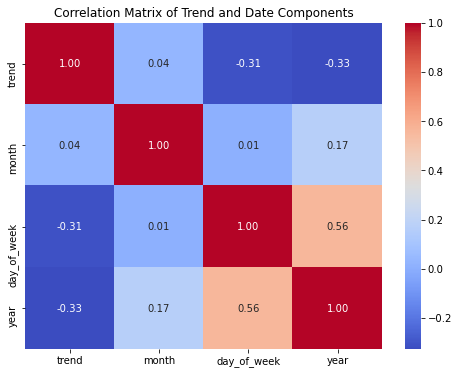

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_data = df_combined[['trend', 'month', 'day_of_week', 'year']]
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Trend and Date Components')
plt.show()

In [50]:
from sklearn.preprocessing import MultiLabelBinarizer

# Create a MultiLabelBinarizer instance
mlb = MultiLabelBinarizer()

# Fit and transform the 'genre_ids' column
genre_encoded = mlb.fit_transform(df_combined['genre_ids'])

# Create a DataFrame from the one-hot encoded genres
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df_combined.index)

# Concatenate the new genre DataFrame with the original DataFrame and drop the original 'genre_ids' column
df_combined = pd.concat([df_combined.drop('genre_ids', axis=1), genre_df], axis=1)

display(df_combined.head())

,titolo,overview,anno_uscita,categoria,trend,month,day_of_week,year,Action & Adventure,Animazione,...,Famiglia,Kids,Mistero,News,Reality,Romance,Sci-Fi & Fantasy,Soap,Storia,Thriller
0,Diamanti,"Un regista convoca le sue attrici preferite, q...",2024-12-19,film,7.947188,12,3,2024,0,0,...,0,0,0,0,0,0,0,0,0,0
1,E poi si vede,"Tre case, tre ragazzi, lo stesso obiettivo: vi...",2025-03-27,film,5.741745,3,3,2025,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mantis,,2025-09-19,film,4.680851,9,4,2025,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Diciannove,Il film racconta la storia di un diciannovenne...,2025-02-27,film,5.394304,2,3,2025,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Elisa,"Elisa, una ragazza di buona famiglia è in car...",2025-09-05,film,3.849163,9,4,2025,0,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
# Select only the genre columns and the 'trend' column
genre_and_trend_df = df_combined.select_dtypes(include='number').drop(columns=['month', 'day_of_week', 'year']).copy()

# Calculate the correlation matrix
correlation_matrix_genres = genre_and_trend_df.corr()

# Extract the correlation values between 'trend' and each genre
genre_trend_correlation = correlation_matrix_genres['trend'].drop('trend')

# Display the correlation values
display(genre_trend_correlation)

Action & Adventure    0.180192
Animazione            0.197584
Commedia              0.173699
Crime                 0.072015
Documentario         -0.156464
Dramma                0.168768
Famiglia              0.184218
Kids                  0.197584
Mistero               0.296708
News                  0.054908
Reality               0.119073
Romance              -0.091932
Sci-Fi & Fantasy      0.129415
Soap                  0.280733
Storia               -0.218961
Thriller             -0.095362
Name: trend, dtype: float64

In [52]:
# Explode the 'Generi' column
df_exploded = df_combined_ordinato.explode('Generi')

# Group by genre and calculate the mean trend
genre_ranking = df_exploded.groupby('Generi')['trend'].mean()

# Sort the ranking in descending order
genre_ranking_sorted = genre_ranking.sort_values(ascending=False)

# Display the sorted genre ranking
display(genre_ranking_sorted)

Generi
Soap                  6.810446
Mistero               6.500468
Animazione            6.192067
Kids                  6.192067
Sci-Fi & Fantasy      6.101556
Action & Adventure    5.802321
Famiglia              5.665554
Reality               5.436103
News                  5.130987
Commedia              5.126506
Crime                 5.091246
Dramma                4.957744
Romance               4.038938
Thriller              4.013427
Storia                3.094222
Documentario          3.055515
Name: trend, dtype: float64

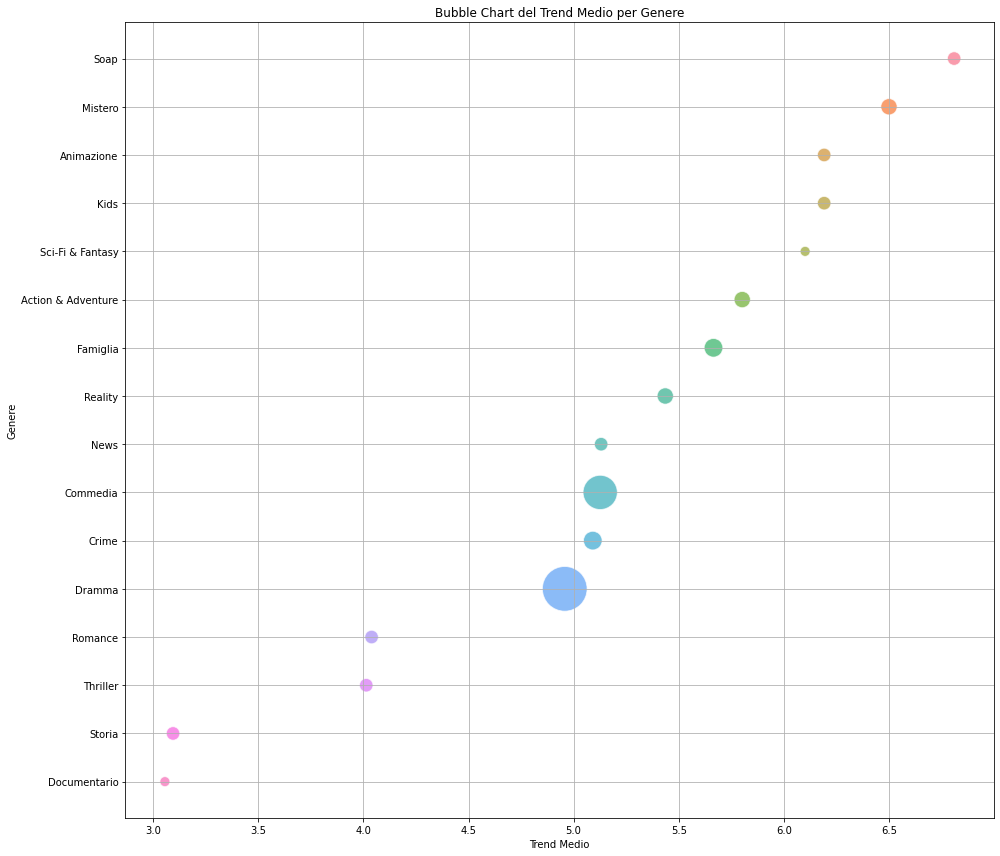

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola il numero di titoli per ogni genere nel DataFrame esploso
genre_counts = df_exploded['Generi'].value_counts().reset_index()
genre_counts.columns = ['Generi', 'Numero di Titoli']

# Unisci il ranking per genere con il conteggio dei titoli
genre_ranking_with_counts = pd.merge(genre_ranking_sorted.reset_index(), genre_counts, on='Generi')
genre_ranking_with_counts.rename(columns={'trend': 'Trend Medio'}, inplace=True)


# Crea un bubble chart con colori diversi per ogni genere e altezza maggiore
plt.figure(figsize=(14, 12)) # Aumenta l'altezza per ridurre lo spazio verticale tra le bolle
sns.scatterplot(data=genre_ranking_with_counts, x='Trend Medio', y='Generi', size='Numero di Titoli', sizes=(100, 2000), alpha=0.7, hue='Generi', legend=False) # Aggiungi 'hue' per colorare per genere

plt.title('Bubble Chart del Trend Medio per Genere')
plt.xlabel('Trend Medio')
plt.ylabel('Genere')
plt.grid(True)
plt.tight_layout() # Assicura che le etichette non vengano tagliate
plt.show()

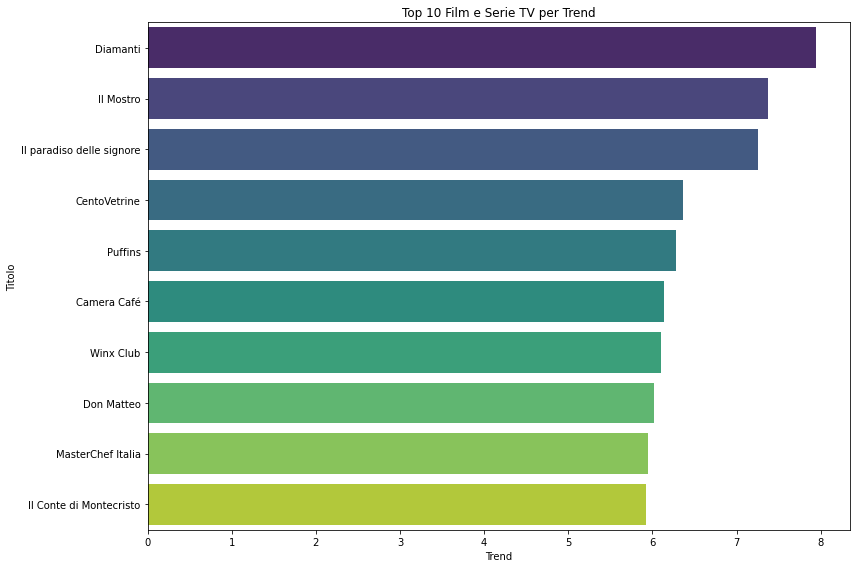

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordina il DataFrame per la colonna 'trend' in ordine decrescente e seleziona i primi 10
top_10_titoli = df_combined.sort_values(by='trend', ascending=False).head(10)

# Crea un grafico a barre per i primi 10 titoli
plt.figure(figsize=(12, 8))
sns.barplot(x='trend', y='titolo', data=top_10_titoli, palette='viridis')
plt.title('Top 10 Film e Serie TV per Trend')
plt.xlabel('Trend')
plt.ylabel('Titolo')
plt.tight_layout()
plt.show()

In [55]:
top_10_titoli.to_csv('previous_top_10.csv', index=False)

In [56]:
import os

file_path = 'previous_top_10.csv'

if os.path.exists(file_path):
    previous_top_10_titoli = pd.read_csv(file_path)
else:
    # Create an empty DataFrame with the same columns as top_10_titoli
    previous_top_10_titoli = pd.DataFrame(columns=top_10_titoli.columns)

display(previous_top_10_titoli.head())

,titolo,overview,anno_uscita,categoria,trend,month,day_of_week,year,Action & Adventure,Animazione,...,Famiglia,Kids,Mistero,News,Reality,Romance,Sci-Fi & Fantasy,Soap,Storia,Thriller
0,Diamanti,"Un regista convoca le sue attrici preferite, q...",2024-12-19,film,7.947188,12,3,2024,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Il Mostro,Un serial killer che prende di mira le coppie ...,2025-10-22,serie,7.380170,10,2,2025,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Il paradiso delle signore,"Le storie, gli amori, le speranze e le delusio...",2015-12-08,serie,7.254226,12,1,2015,0,0,...,0,0,0,0,0,0,0,1,0,0
3,CentoVetrine,La serie racconta varie storie di alcuni dei p...,2001-01-08,serie,6.366667,1,0,2001,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Puffins,La serie è incentrata sulle avventure vissute ...,2020-11-27,serie,6.282579,11,4,2020,0,1,...,1,1,0,0,0,0,0,0,0,0


In [57]:
current_top_10_titles = set(top_10_titoli['titolo'])
previous_top_10_titles = set(previous_top_10_titoli['titolo'])

are_different = True

display(are_different)

True

In [58]:
if are_different:
    discord_message = "🚨 **Aggiornamento Top 10 Film e Serie TV!** 🚨\n\nLa classifica dei titoli più in voga è cambiata!\n\n**Nuova Top 10:**\n"
    for i, (index, row) in enumerate(top_10_titoli.iterrows()): # Usa enumerate per un contatore
        discord_message += f"{i + 1}. {row['titolo']} ({row['categoria']})\n" # Usa il contatore i + 1 per la numerazione
    display(discord_message)
else:
    print("No changes in the top 10. No notification needed.")

'🚨 **Aggiornamento Top 10 Film e Serie TV!** 🚨\n\nLa classifica dei titoli più in voga è cambiata!\n\n**Nuova Top 10:**\n1. Diamanti (film)\n2. Il Mostro (serie)\n3. Il paradiso delle signore (serie)\n4. CentoVetrine (serie)\n5. Puffins (serie)\n6. Camera Café (serie)\n7. Winx Club (serie)\n8. Don Matteo (serie)\n9. MasterChef Italia (serie)\n10. Il Conte di Montecristo (serie)\n'

In [59]:
pip install schedule

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import schedule
import time
from datetime import datetime

# Configurazione
discord_webhook_url = ""
#Cambiare mail com mail reali
email_recipients = [
    "emailprova@gmail.com",
]

# Configurazione email SMTP (Gmail)
SMTP_SERVER = ""
SMTP_PORT = 465
SENDER_EMAIL = ""  # Sostituisci con la tua email
SENDER_PASSWORD = ""  #

def send_email(subject, body, recipients):
    """Invia email ai destinatari specificati"""
    try:
        msg = MIMEMultipart()
        msg['From'] = SENDER_EMAIL
        msg['To'] = ", ".join(recipients)
        msg['Subject'] = subject
        
        msg.attach(MIMEText(body, 'plain'))
        
        server = smtplib.SMTP(SMTP_SERVER, SMTP_PORT)
        server.starttls()
        server.login(SENDER_EMAIL, SENDER_PASSWORD)
        
        server.send_message(msg)
        server.quit()
        
        print(f"Email inviata con successo a {len(recipients)} destinatari")
        return True
    except Exception as e:
        print(f"Errore nell'invio dell'email: {e}")
        return False

def send_discord_notification(message):
    """Invia notifica a Discord"""
    payload = {"content": message}
    try:
        response = requests.post(discord_webhook_url, json=payload)
        response.raise_for_status()
        print(f"Messaggio Discord inviato! Status code: {response.status_code}")
        return True
    except requests.exceptions.RequestException as e:
        print(f"Errore invio Discord: {e}")
        return False

def check_and_notify():
    """Funzione principale che controlla le modifiche e invia notifiche"""
    print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Esecuzione controllo...")
    
    # Qui inserisci la tua logica per controllare le modifiche
    # Esempio:
    are_different = True  # Sostituisci con la tua logica di controllo
    discord_message = "Cambiamenti rilevati nella top 10!"  # Il tuo messaggio
    
    if are_different:
        # Invia notifica Discord
        discord_sent = send_discord_notification(discord_message)
        
        # Prepara e invia email
        email_subject = "Aggiornamento Top 10"
        email_body = f"""
Ciao,

È stato rilevato un cambiamento nella top 10.

Dettagli:
{discord_message}

Questo è un messaggio automatico generato alle {datetime.now().strftime('%H:%M del %d/%m/%Y')}.

Saluti
        """
        
        email_sent = send_email(email_subject, email_body, email_recipients)
        
        if discord_sent and email_sent:
            print("Tutte le notifiche inviate con successo!")
        elif discord_sent:
            print("Discord inviato, ma email fallita")
        elif email_sent:
            print("Email inviata, ma Discord fallito")
        else:
            print("Entrambe le notifiche sono fallite")
    else:
        print("Nessun cambiamento rilevato. Nessuna notifica inviata.")

def run_scheduler():
    """Configura e avvia lo scheduler"""
    # Schedula l'esecuzione ogni giorno alle 9:00
    schedule.every().day.at("12:01").do(check_and_notify)
    
    print("Scheduler avviato! Lo script verrà eseguito ogni giorno alle 12:01")
    print("Premi Ctrl+C per fermare lo scheduler\n")
    
    # Esegui immediatamente una volta per test (opzionale)
    # check_and_notify()
    
    # Loop principale dello scheduler
    while True:
        schedule.run_pending()
        time.sleep(60)  # Controlla ogni minuto

if __name__ == "__main__":
    try:
        run_scheduler()
    except KeyboardInterrupt:
        print("\n\nScheduler fermato dall'utente")
    except Exception as e:
        print(f"\n\nErrore critico: {e}")